# Simulate parabolic PDE with DEM as parameter field

Idea: use sandbox DEM as paramerter field in a parabolic PDE simulation

### import the libraries

In [1]:
import os,sys
import matplotlib.pyplot as plt
sys.path.append('./../../../open_AR_Sandbox')
import sandbox.sandbox as sb

Freenect module not found, KinectV1 will not work.


./../../../open_AR_Sandbox\sandbox\sandbox.py:52: UserWarning: gempy not found, GeoMap Module will not work
  warn('gempy not found, GeoMap Module will not work')


### Setup the projector and Sensor and load a calibration

In [2]:
calib = sb.CalibrationData(file = "my_calibration.json")
sensor = sb.KinectV2(calib)
projector = sb.Projector(calib)

JSON configuration loaded.
KinectV2 initialized.


Projector initialized and server started.
Please position the browser window accordingly and enter fullscreen!


In [3]:
module = sb.NotebookConnection(calib,sensor,projector)
module.setup()

### start prototyping 

In [4]:
import numpy as np
from scipy import sparse  # to define sparse matrices
import scipy.sparse.linalg as ssl
from scipy.sparse import (csr_matrix, coo_matrix, dia_matrix, lil_matrix,
                              dok_matrix, rand, SparseEfficiencyWarning)

In [15]:
def poisson2d_param(N, M, params, dtype='d', format='csc'):
    """
    Return a sparse matrix for the 2D Poisson problem
    with standard 5-point finite difference stencil on a
    square N-by-N grid.
    
    Consider heterogeneities in parameter field (argument params)
    """
    if N == 1:
        diags = np.asarray([[4]], dtype=dtype)
        return dia_matrix((diags, [0]), shape=(1, 1)).asformat(format)

    offsets = np.array([0, -N, N, -1, 1])

    diags = np.empty((5, N*M), dtype=dtype)

    diags[0] = -4  # main diagonal (note: in example it is 4)
    diags[1:] = 1  # all offdiagonals (note: in example, it is -1!)
        
    # temper with parameter fields:
    diags[0] = - 4 * np.ravel(params)
    
    # param_frame = np.ones_like(params) * 4.
    # param_frame[1:-1, 1:-1] = params[:-2, 1:-1] + params[2:, 1:-1] + params[1:-1, 2:] + params[1:-1, :-2]
    
    param_comb = params[:-2, 1:-1] + params[2:, 1:-1] + params[1:-1, 2:] + params[1:-1, :-2]
    param_frame = np.pad(param_comb, (1,1), 'edge')
    
    order_flag = 'F'   # {'C','F', 'A', 'K'}
    
    diags[0] = - np.ravel(param_frame, order=order_flag)
    
    # print(diags[0])
    
    diags[1] = np.ravel(params, order=order_flag)
    diags[2] = np.ravel(params, order=order_flag)
    diags[3] = np.ravel(params, order=order_flag)
    diags[4] = np.ravel(params, order=order_flag)
    
    # set Neumann BCs
    # diags[1, N-1::N] = 2
    diags[3, N-2::N] = 2 * diags[3, N-2::N]
    # diags[1, (N-1)**2:(N-1)**2+N] = 2
    # diags[2, :2*N] = 2
    diags[4, 1::N] = 2 * diags[4, 1::N]
    # diags[3, (N-1)*N:] =2
    
    # diags[3, :] = 2
    
    # as before:
    diags[3, N-1::N] = 0  # first lower diagonal
    diags[4, N::N] = 0  # first upper diagonal
    
    # print(diags)

    return dia_matrix((diags, offsets), shape=(N*M, N*M)).asformat(format)



def scale_dem(sandbox_dem):
    params = 1 + (sandbox_dem - np.min(sandbox_dem)) /\
    (np.max(sandbox_dem) - np.min(sandbox_dem))
    return params**2

def run_sim(params):
    n = 150
    m = 200
    n, m = params.shape
    T = poisson2d_param(n, m, params)
    # set value with boundary conditions
    b = np.zeros(n * m)
    b_val = 20
    b[:n] = -b_val
    b[-n:] = b_val
    # solve
    u = ssl.spsolve(T, b)
    u2 = u.reshape(m,n)
    return u2

def plot_field(u, ax=None):
    n,m = u.shape
    x = np.linspace(0, 10, n)
    y = np.linspace(0, 10, m)
    X,Y = np.meshgrid(x,y)
    # fig = plt.figure(figsize=(12,12))
    # ax = fig.add_subplot(111, projection='3d')
    # ax.plot_surface(X, Y, u2, cmap='viridis', cstride=2, rstride=2) # my new favourite colormap

    #fig = plt.figure(figsize=(14,8))
    # 
    #ax.contourf(sandbox_dems[dem_id,:,:])
    ax.contourf(u.T, 25, cmap='RdBu')
    #ax.axis('equal')
    #ax.set_xlim([0,200])
    #ax.set_ylim([0,150])
    #ax.tight_layout()
    

def plot_quiver(u, params, ax=None):
    n,m = u.shape
    n_steps = 10
    y = np.linspace(0,m,int(m/n_steps))
    x = np.linspace(0,n,int(n/n_steps))
    X,Y = np.meshgrid(x,y)

    #fig = plt.figure(figsize=(12,8))
    ax.contourf(params, 25)
    ax.quiver(X, Y, -np.gradient(u)[0][::n_steps,::n_steps],  -np.gradient(u)[1][::n_steps,::n_steps])
    #plt.axis('equal')
    #plt.xlim([0,200])
    #plt.ylim([0,150])
    #plt.tight_layout()
    #ax=plt.gca()
    #return fig, ax

def plot_streamlines(u, params, plot_lines=True, savefig=False, fig_filename="dtm_streamlines.png", ax = None):
    n,m = u.shape
    n_steps = 10
    y = np.linspace(0,m,int(m/n_steps+1))
    x = np.linspace(0,n,int(n/n_steps+1))
    X,Y = np.meshgrid(x,y)
    
    # print(X.shape)

    #fig = plt.figure(figsize=(12,8))
    # plt.contourf(u2.T)
    ax.contourf(params, 25)
    #plt.colorbar()
    # plt.quiver(X, Y, -np.gradient(u2)[0].T[::n_steps,::n_steps],  -np.gradient(u2)[1].T[::n_steps,::n_steps])
    #plt.axis('equal')
    speed = 1/np.sqrt(np.gradient(u)[0].T[::n_steps,::n_steps]**2 + np.gradient(u)[1].T[::n_steps,::n_steps]**2)
    lw = 10*speed / speed.max()
    tmp = -np.gradient(u)[0].T[::n_steps,::n_steps]
    # print(tmp.shape)
    if plot_lines:
        ax.streamplot(X, Y,-np.gradient(u)[0].T[::n_steps,::n_steps],  -np.gradient(u)[1].T[::n_steps,::n_steps],
                      linewidth=lw,
                      color='w',
                       arrowsize = 2.,
                      integration_direction='forward')
    # plt.xlim([0,200])
    # plt.ylim([0,150])
    #plt.tight_layout()
    if savefig:
        plt.savefig(fig_filename)
    #ax = plt.gca()
    
    #return fig, ax

In [19]:
def plot_from_notebook(sandbox_ax, sandbox_frame, select = 3):
    params = scale_dem(sandbox_frame)
    u = run_sim(params)
    if select ==1:
        plot_field(u, ax=sandbox_ax)
    elif select ==2:
        plot_quiver(u, params, ax=sandbox_ax)
    elif select ==3:
        plot_streamlines(u, params, ax = sandbox_ax)
    

    
    

In [24]:
module.function_to_run = module.plot_sandbox(plot_from_notebook)

In [25]:
module.run()

Thread already running.


In [26]:
module.active_connection = True

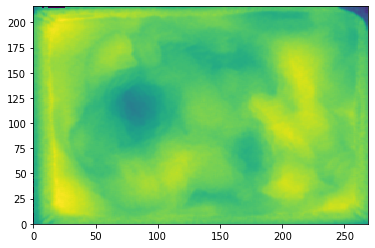

In [6]:
depth = sensor.get_frame()
cropped_depth = module.clip_frame(module.crop_frame(depth))
params = scale_dem(cropped_depth)
u = run_sim(params)
plt.pcolormesh(cropped_depth)

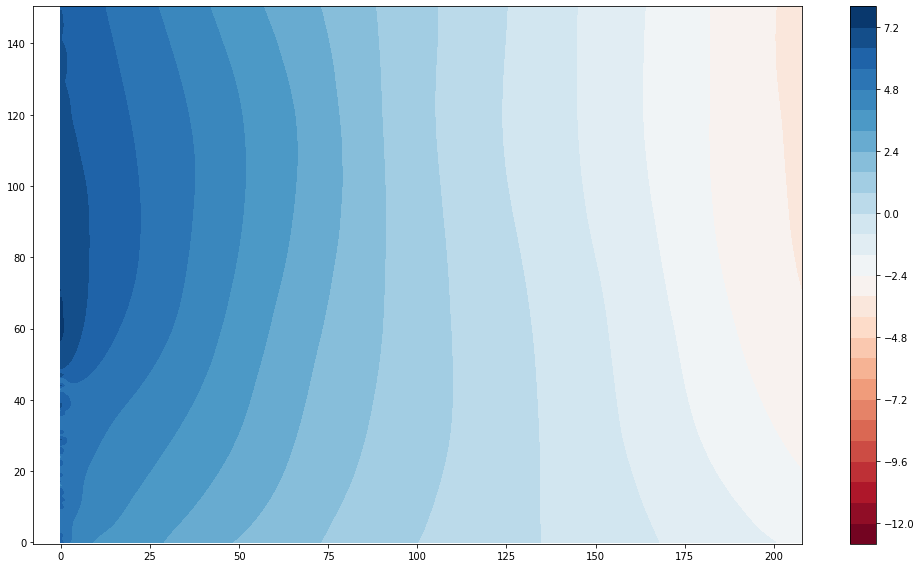

In [7]:
fig, ax = plot_field(u)


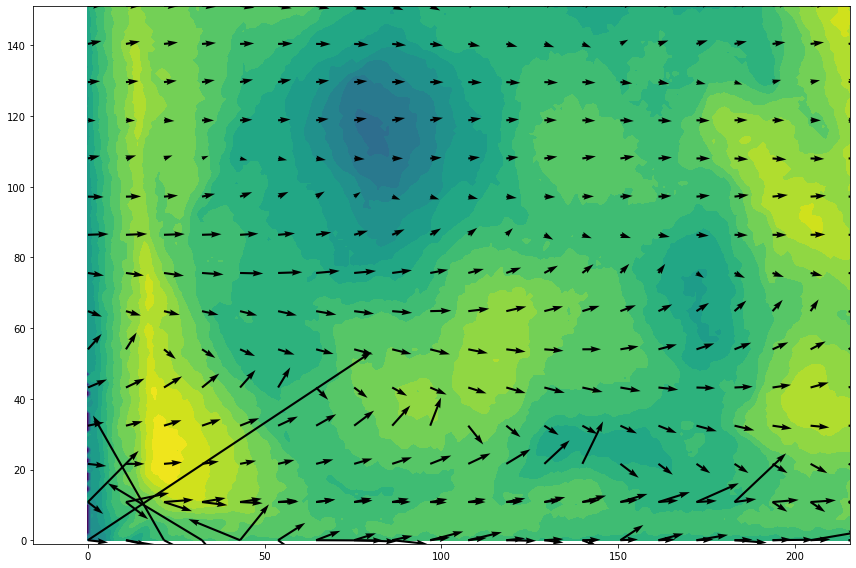

In [8]:
fig, ax = plot_quiver(u)


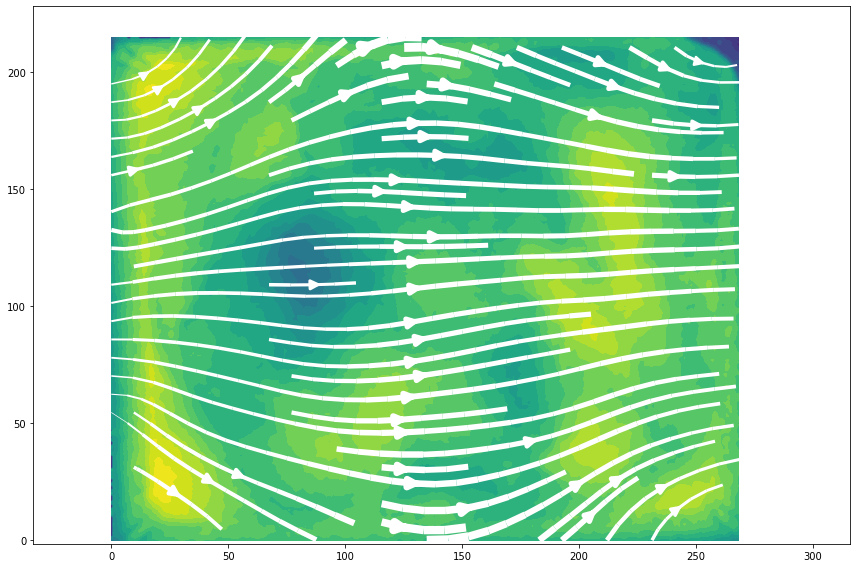

In [9]:
fig, ax = plot_streamlines(u)


In [18]:
ax.cla()

In [79]:
projector.frame.object =fig


In [47]:
projector.trigger()

True

In [44]:
module.run()

Thread started or resumed...


In [45]:
module.stop()

Thread stopped.


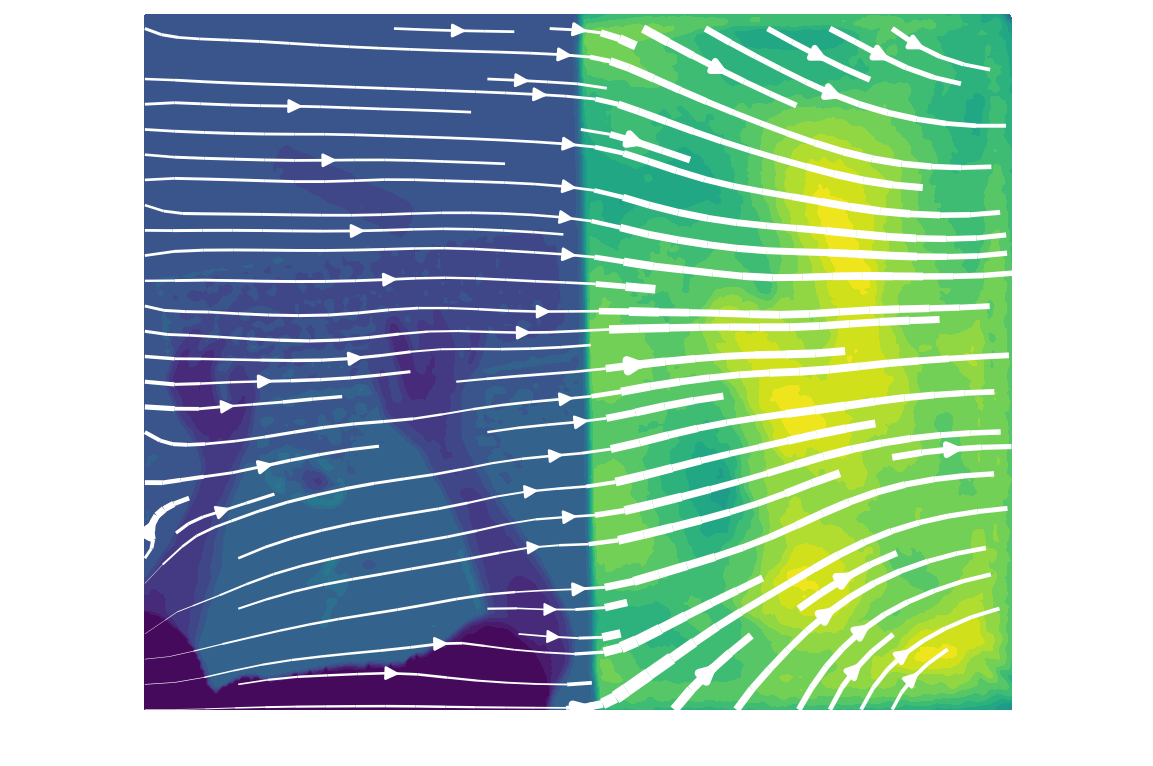

In [78]:
fig

In [74]:
ax.set_axis_off()

In [77]:
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [36]:
np.random.randn(30)

array([-0.69484583,  0.45089469, -0.94283055, -0.65018833,  0.70649451,
       -0.80794519, -0.82332907, -1.04882578, -0.97090114, -2.18046554,
       -0.07743186, -1.44544492, -1.4340749 , -0.93504389, -0.21732375,
        0.65590872, -1.09470181,  0.4275952 ,  1.0253876 ,  0.57028038,
        1.25172667,  0.6006505 ,  0.73871782, -0.81509957,  0.48139913,
        0.58514639,  0.02431592, -0.12359261, -0.35719978, -1.54229658])